In [42]:
# RQ3: What types of reviewer comments do AI-generated PRs receive, and what patterns emerge across different AI models?

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load the Dataset + convert to pandas
ai_pull_request = load_dataset("hao-li/AIDev", "all_pull_request")["train"].to_pandas()[["id", "agent"]]
pr_comments = load_dataset("hao-li/AIDev", "pr_comments")["train"].to_pandas()[["pr_id", "body"]]
review = load_dataset("hao-li/AIDev", "pr_reviews")["train"].to_pandas()[["id", "pr_id", "body"]]
review_comments_1 = load_dataset("hao-li/AIDev", "pr_review_comments")["train"].to_pandas()[["id", "pull_request_review_id", "body"]]
review_comments_2 = load_dataset("hao-li/AIDev", "pr_review_comments_v2")["train"].to_pandas()[["id", "pull_request_review_id", "body"]]

# Data Cleansing
print("Missing values in ai_pull_request:")
print(ai_pull_request.isna().sum())
print("\nMissing values in pr_comments:")
print(pr_comments.isna().sum())
print("\nMissing values in pr_reviews:")
print(review.isna().sum())
print("\nMissing values in pr_review_comments v1:")
print(review_comments_1.isna().sum())
print("\nMissing values in pr_review_comments v2:")
print(review_comments_2.isna().sum())


# Clean general PR comments
pr_comments["body"] = pr_comments["body"].fillna("").str.strip()

# Clean review summary bodies
review["body"] = review["body"].fillna("").str.strip()

# Clean inline review comments
review_comments_1["body"] = review_comments_1["body"].fillna("").str.strip()
review_comments_2["body"] = review_comments_2["body"].fillna("").str.strip()

# Remove completely empty PR comments 
pr_comments = pr_comments[pr_comments["body"] != ""]

print("Empty bodies in pr_comments:", (pr_comments['body']=="").sum())
print("Empty bodies in review:", (review['body']=="").sum())
print("Empty bodies in review_comments_1:", (review_comments_1['body']=="").sum())
print("Empty bodies in review_comments_2:", (review_comments_2['body']=="").sum())

Missing values in ai_pull_request:
id       0
agent    0
dtype: int64

Missing values in pr_comments:
pr_id    0
body     0
dtype: int64

Missing values in pr_reviews:
id           0
pr_id        0
body     20934
dtype: int64

Missing values in pr_review_comments v1:
id                        0
pull_request_review_id    0
body                      1
dtype: int64

Missing values in pr_review_comments v2:
id                        0
pull_request_review_id    0
body                      1
dtype: int64
Empty bodies in pr_comments: 0
Empty bodies in review: 20935
Empty bodies in review_comments_1: 1
Empty bodies in review_comments_2: 1


In [44]:
# Create PR (AI Model mapping table) 
df_pr_type = ai_pull_request.rename(columns={"id": "pr_id", "agent": "model"})

#df_pr_type.head()

# join PR type into general comments
comments_with_type = pr_comments.merge(
    df_pr_type,
    on="pr_id",
    how="left"
)

# comments_with_type.head()

# map inline comments to PR via review table
review_comments_1_mapped = review_comments_1.merge(
    review[["id", "pr_id"]],
    left_on="pull_request_review_id",
    right_on="id",
    how="left"
)[["pr_id", "body"]]

# for v2 inline comments
review_comments_2_mapped = review_comments_2.merge(
    review[["id", "pr_id"]],
    left_on="pull_request_review_id",
    right_on="id",
    how="left"
)[["pr_id", "body"]]

#review_comments_1_mapped.head()

# add PR type to inline comments
inline_1_with_type = review_comments_1_mapped.merge(
    df_pr_type,
    on="pr_id",
    how="left"
)[["pr_id", "body", "model"]]

inline_2_with_type = review_comments_2_mapped.merge(
    df_pr_type,
    on="pr_id",
    how="left"
)[["pr_id", "body", "model"]]

inline_all = pd.concat([inline_1_with_type, inline_2_with_type], ignore_index=True)

inline_all.head()

,pr_id,body,model
0,3201567268,These constants aren't used anywhere.,Claude_Code
1,3132739442,Have we formally decided for/against using spe...,Claude_Code
2,3078006902,✅,Claude_Code
3,3132739442,```suggestion\n```,Claude_Code
4,3132093324,"```suggestion\r\n ""Legacy suppo...",Claude_Code


In [45]:
# combine general and inline comments into one dataset

#select only needed columns
general_comments = comments_with_type[["pr_id", "body", "model"]]
inline_comments = inline_all[["pr_id", "body", "model"]]

#combine
all_comments = pd.concat([general_comments, inline_comments], ignore_index=True)

print(all_comments.head())
print("\nAI model counts in all comments:")
print(all_comments["model"].value_counts())
print("\nTotal comments:", len(all_comments))

        pr_id                                               body        model
0  3107321792  <!-- This is an auto-generated comment: summar...  Claude_Code
1  3234660269  claude budget reached, development is on hold ...  Claude_Code
2  3037457814  Hi, thanks for sharing and contributing! Pleas...  Claude_Code
3  2915198291  ## Deploying instructor-py with &nbsp;<a href=...  Claude_Code
4  3132410695  Can you rebase it to the current master? Pleas...  Claude_Code

AI model counts in all comments:
model
Copilot         43114
Devin           23593
OpenAI_Codex    12003
Cursor           4301
Claude_Code      2429
Name: count, dtype: int64

Total comments: 85440


In [46]:
all_pr = load_dataset("hao-li/AIDev", "all_pull_request")["train"].to_pandas()[["id", "agent"]]

df_pr_type = all_pr.rename(columns={"agent": "pr_type"})
df_pr_type.pr_type.value_counts()

pr_type
OpenAI_Codex    814522
Copilot          50447
Cursor           32941
Devin            29744
Claude_Code       5137
Name: count, dtype: int64

In [47]:
# Define a function to classify each comment into a category
# Keyword-based classification rules

def classify_comment(text):
    t = text.lower()

    if any(w in t for w in ["bug", "wrong", "incorrect", "fix", "error"]):
        return "correctness"
    elif any(w in t for w in ["test", "coverage", "assert"]):
        return "missing_tests"
    elif any(w in t for w in ["format", "naming", "style", "indent", "lint"]):
        return "style"
    elif any(w in t for w in ["doc", "readme", "documentation", "comment"]):
        return "documentation"
    elif any(w in t for w in ["unsafe", "insecure", "vulnerability", "security"]):
        return "security"
    else:
        return "other"

all_comments["category"] = all_comments["body"].apply(classify_comment)
all_comments.head()

#test
all_comments["category"].value_counts()


category
other            36592
correctness      25346
missing_tests    14002
documentation     5789
style             2762
security           949
Name: count, dtype: int64

In [48]:
#Compare reviewer comment categories across AI models
model_category_counts = all_comments.groupby(["model", "category"]).size().reset_index(name="count")
model_category_counts


,model,category,count
0,Claude_Code,correctness,946
1,Claude_Code,documentation,150
2,Claude_Code,missing_tests,345
3,Claude_Code,other,854
4,Claude_Code,security,93
5,Claude_Code,style,41
6,Copilot,correctness,10735
7,Copilot,documentation,2968
8,Copilot,missing_tests,6111
9,Copilot,other,21446


<Figure size 1200x600 with 0 Axes>

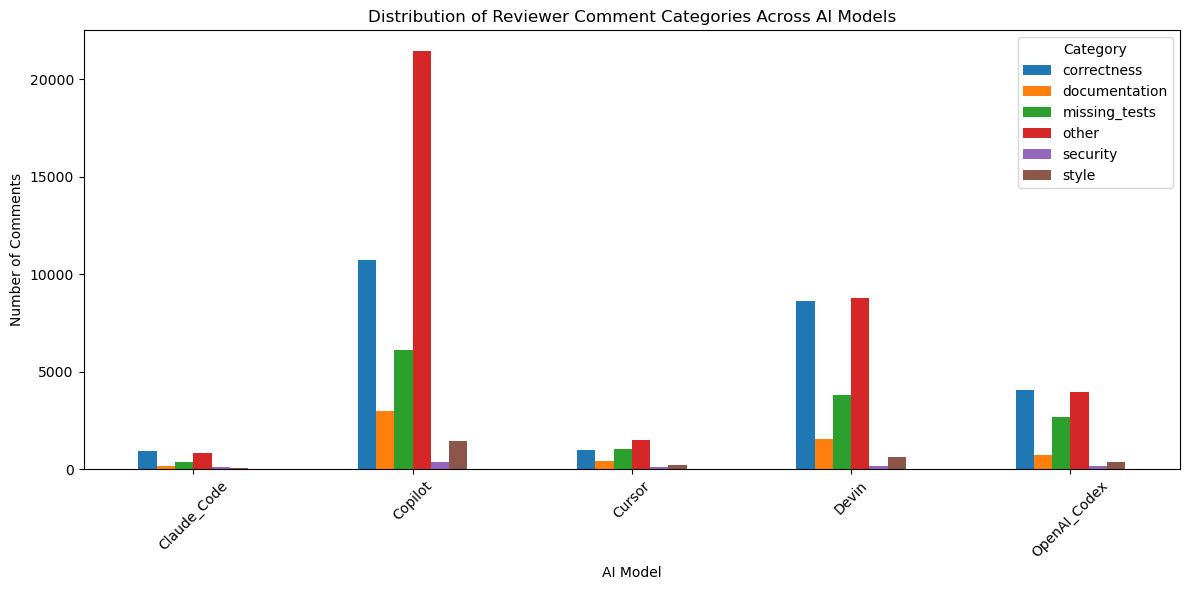

In [54]:
#vis

plt.figure(figsize=(12,6))
pivot_table.plot(kind="bar", figsize=(12,6))
plt.title("Distribution of Reviewer Comment Categories Across AI Models")
plt.xlabel("AI Model")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.tight_layout()
plt.show()

In [49]:
pivot_table = model_category_counts.pivot(index="model", columns="category", values="count").fillna(0)
pivot_table


category,correctness,documentation,missing_tests,other,security,style
model,,,,,,
Claude_Code,946,150,345,854,93,41
Copilot,10735,2968,6111,21446,382,1472
Cursor,993,396,1044,1517,118,233
Devin,8626,1534,3811,8803,184,635
OpenAI_Codex,4046,741,2691,3972,172,381


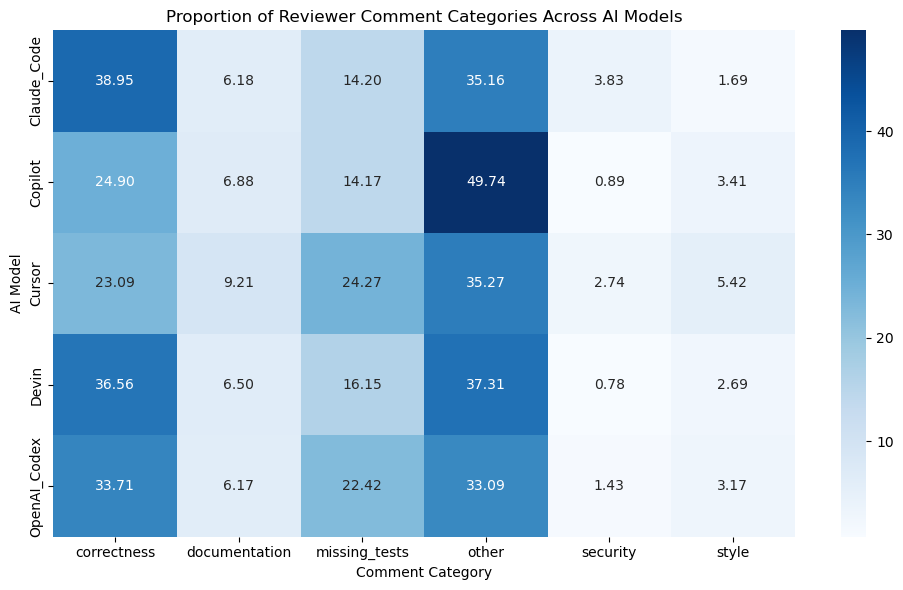

In [53]:
# Proportion of comment categories for each AI model
import seaborn as sns

proportion_table = pivot_table.div(pivot_table.sum(axis=1), axis=0)
percentage_table = proportion_table * 100
percentage_table = percentage_table.round(2)   

plt.figure(figsize=(10,6))
sns.heatmap(percentage_table, annot=True, cmap="Blues", fmt=".2f")
plt.title("Proportion of Reviewer Comment Categories Across AI Models")
plt.xlabel("Comment Category")
plt.ylabel("AI Model")
plt.tight_layout()
plt.show()

